#Dự đoán thời gian giao đồ ăn

Để dự đoán thời gian giao đồ ăn theo thời gian thực, chúng ta cần tính khoảng cách giữa điểm chuẩn bị đồ ăn và điểm tiêu thụ đồ ăn. Sau khi tìm khoảng cách giữa nhà hàng và các địa điểm giao hàng, chúng ta cần tìm mối liên hệ giữa thời gian mà các đối tác giao hàng thực hiện để giao đồ ăn trước đây cho cùng một khoảng cách.


In [20]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path='/content/drive/MyDrive/Dataset/deliverytime.txt'
data = pd.read_csv(path)
data

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30
...,...,...,...,...,...,...,...,...,...,...,...
45588,7C09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,Meal,motorcycle,32
45589,D641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,Buffet,motorcycle,36
45590,4F8D,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,Drinks,scooter,16
45591,5EEE,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,Snack,motorcycle,26


ID: mã số đơn hàng


Delivery_person_ID: Mã số của đối tác giao hàng


Delivery_person_Age: Tuổi của đối tác giao hàng


Delivery_person_Ratings: xếp hạng của đối tác giao hàng dựa trên các lần giao

hàng trước đây
Restaurant_latitude: Vĩ độ của nhà hàng


Restaurant_longitude: Kinh độ của nhà hàng


Delivery_location_latitude: Vĩ độ của địa điểm giao hàng


Delivery_location_longitude: Kinh độ của địa điểm giao hàng


Type_of_order: Loại suất ăn khách hàng đặt


Loại_phương tiện: Loại phương tiện mà đối tác giao hàng sử dụng


Time_taken(min): Thời gian mà đối tác giao hàng cần để hoàn thành đơn hàng



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


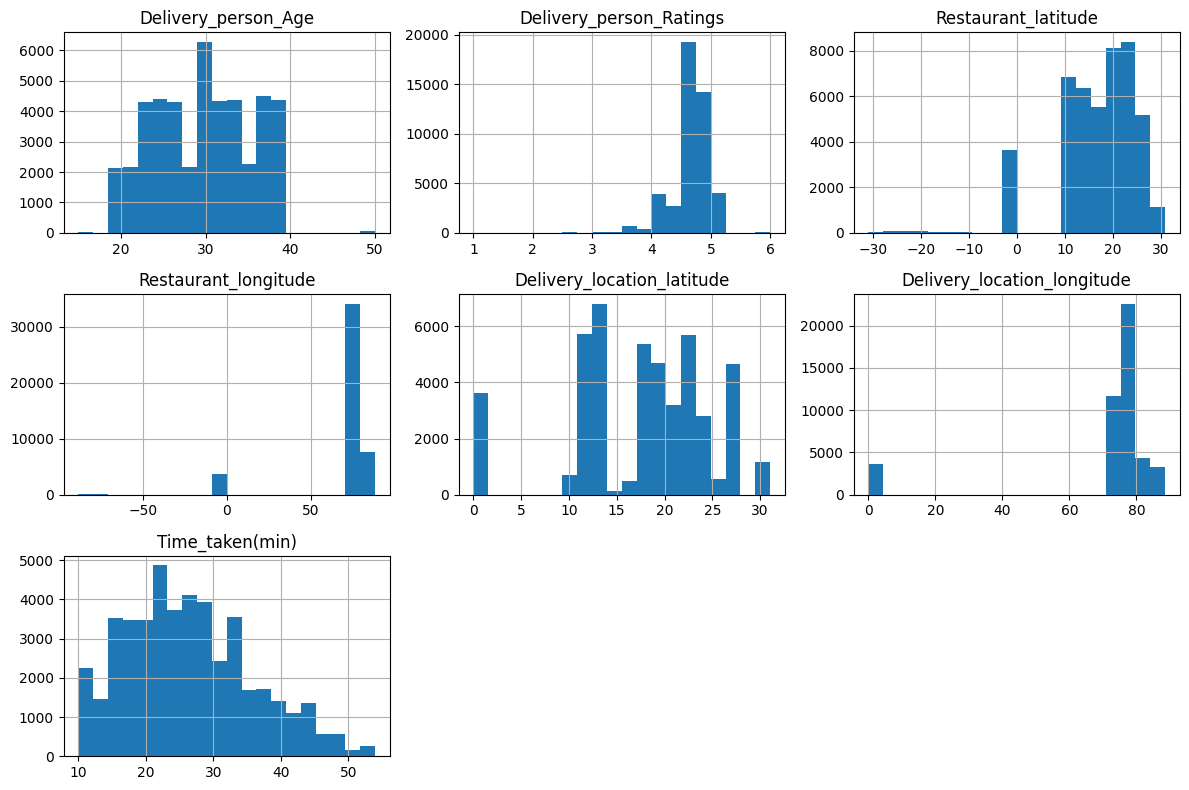

In [19]:
data.hist(bins=20,figsize=(12,8))
plt.tight_layout()

In [13]:
dups = data.duplicated()
print('Kết quả',dups.any())
print('Số dữ liệu trùng lặp',dups.any().sum())
print('Dữ liệu bị lặp')
print(data[dups])


Kết quả False
Số dữ liệu trùng lặp 0
Dữ liệu bị lặp
Empty DataFrame
Columns: [ID, Delivery_person_ID, Delivery_person_Age, Delivery_person_Ratings, Restaurant_latitude, Restaurant_longitude, Delivery_location_latitude, Delivery_location_longitude, Type_of_order, Type_of_vehicle, Time_taken(min)]
Index: []


In [4]:
data.isna().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Time_taken(min)                0
dtype: int64

Tính khoảng cách giữa hai vĩ độ và kinh độ


Tập dữ liệu không có bất kỳ tính năng nào cho thấy sự khác biệt giữa nhà hàng và địa điểm giao hàng. Tất cả những gì ta có là các điểm kinh độ và vĩ độ của nhà hàng và địa điểm giao hàng.Có thể sử dụng công thức Haversine để tính khoảng cách giữa hai vị trí dựa trên vĩ độ và kinh độ của chúng.

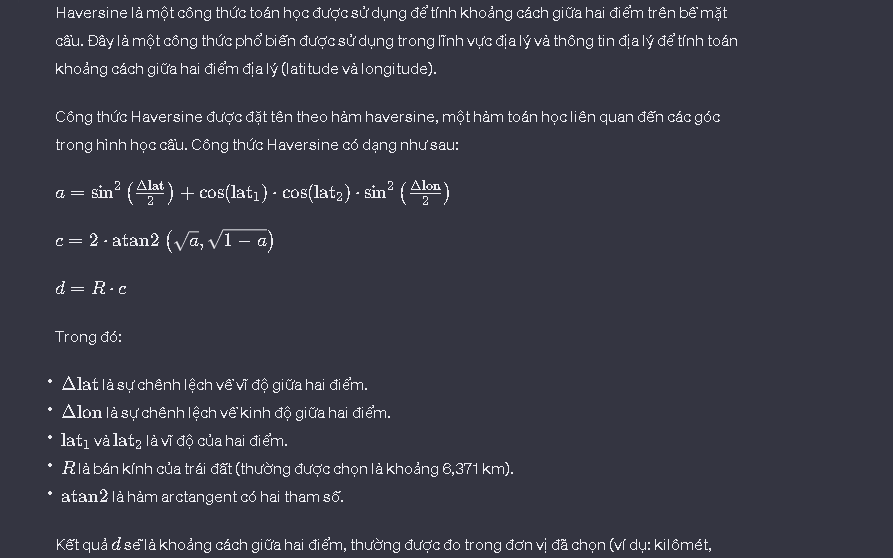

In [ ]:
# đặt bán kính trái đất
R = 6371
# đổi độ sang radians
def deg_to_rad(degrees):
  return degrees *(np.pi/180)

# hàm tính khoảng cách 2 điểm bằng Haversine
def distcalculate(lat1, lon1, lat2, lon2):
    d_lat = deg_to_rad(lat2-lat1)
    d_lon = deg_to_rad(lon2-lon1)
    a = np.sin(d_lat/2)**2 + np.cos(deg_to_rad(lat1)) * np.cos(deg_to_rad(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# tạo cột mới với dữ liệu nan để tính khoảng cách
data['distance'] = np.nan

# tính khoảng cách giữa mỗi cặp điểm
for i in range(len(data)):
    data.loc[i, 'distance'] = distcalculate(data.loc[i, 'Restaurant_latitude'],
                                        data.loc[i, 'Restaurant_longitude'],
                                        data.loc[i, 'Delivery_location_latitude'],
                                        data.loc[i, 'Delivery_location_longitude'])

In [ ]:
#cột distance
data['distance']

0         3.025149
1        20.183530
2         1.552758
3         7.790401
4         6.210138
           ...    
45588     1.489846
45589    11.007735
45590     4.657195
45591     6.232393
45592    12.074396
Name: distance, Length: 45593, dtype: float64

# Tìm hiểu dữ liệu bằng cách trực quan hóa

In [ ]:
fig = px.scatter(data_frame=data,
                 x='distance',
                 y='Time_taken(min)',
                 size='Time_taken(min)',
                 trendline="ols",
                 title = "Relationship Between Distance and Time Taken"
                 )
fig.show()
# trendline="ols" đường xu hướng hồi quy tuyến tính vào biểu đồ phân tán bằng cách sử dụng phương pháp Ordinary Least Squares (OLS).

Output hidden; open in https://colab.research.google.com to view.

Ta thấy được đồ ăn sẽ được giao vào khoảng tầm 20 đến 30 phút trong mọi khoảng cách

In [ ]:
fig = px.scatter(data_frame=data,
                 x='Delivery_person_Age',
                 y='Time_taken(min)',
                 size='Time_taken(min)',
                 color = "distance",
                 trendline="ols",
                 title = "Relationship Between Time Taken and Age"
                 )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Biểu đồ cho ta thấy được các đối tác giao hàng càng nhỏ tuổi thì sẽ có thời gian giao hàng nhanh hơn các đối tác lớn tuổi

In [ ]:
fig = px.scatter(data_frame=data,
                 x='Delivery_person_Ratings',
                 y='Time_taken(min)',
                 size='Time_taken(min)',
                 color = "distance",
                 trendline="ols",
                 title = "Relationship Between Time Taken and Ratings"
                 )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Biểu đồ cho thấy các xếp hạng càng cao thì thời gian giao hàng càng nhanh và ngược lại

In [ ]:
fig = px.box(data,
             x="Type_of_vehicle",
             y="Time_taken(min)",
             color="Type_of_order")
fig.show()

Nhìn biểu đồ ta thấy không có nhiều khác biệt giữa thời gian mà các đối tác giao hàng thực hiện tùy thuộc vào phương tiện họ đang lái và loại thực phẩm họ đang giao.

Vì vậy, các tính năng đóng góp nhiều nhất vào thời gian giao đồ ăn dựa trên phân tích là:




1.Tuổi của đối tác giao hàng


2.Đánh giá của đối tác giao hàng


3.Khoảng cách giữa nhà hàng và địa điểm giao hàng













# mô hình
Chúng ta sẽ đi xây dựng mô hình mạng thần kinh LSTM cho nhiệm vụ dự đoán thời gian giao thực phẩm

In [ ]:
# cắt data
x = np.array(data[["Delivery_person_Age",
                   "Delivery_person_Ratings",
                   "distance"]])
y = np.array(data[["Time_taken(min)"]])

xtrain, xtest, ytrain, ytest = train_test_split(x, y,test_size=0.10,random_state=42)

In [ ]:
# mô hình
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (xtrain.shape[1],1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# training
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(xtrain,ytrain,batch_size=1,epochs=9)


Epoch 1/9
41033/41033 [==============================] - 234s 6ms/step - loss: 58.7790
Epoch 2/9
41033/41033 [==============================] - 233s 6ms/step - loss: 58.7496
Epoch 3/9
41033/41033 [==============================] - 236s 6ms/step - loss: 58.2333
Epoch 4/9
41033/41033 [==============================] - 232s 6ms/step - loss: 58.3278
Epoch 5/9
41033/41033 [==============================] - 222s 5ms/step - loss: 58.0553
Epoch 6/9
41033/41033 [==============================] - 246s 6ms/step - loss: 58.1378
Epoch 7/9
41033/41033 [==============================] - 243s 6ms/step - loss: 58.4920
Epoch 8/9
41033/41033 [==============================] - 246s 6ms/step - loss: 58.0428
Epoch 9/9
41033/41033 [==============================] - 248s 6ms/step - loss: 58.0065


# Test


In [ ]:
print("Food Delivery Time Prediction")
a = int(input("Age of Delivery Partner: "))
b = float(input("Ratings of Previous Deliveries: "))
c = int(input("Total Distance: "))

features = np.array([[a, b, c]])
print("Predicted Delivery Time in Minutes = ", model.predict(features),'min')

Food Delivery Time Prediction
Age of Delivery Partner: 29
Ratings of Previous Deliveries: 4.9
Total Distance: 9
1/1 [==============================] - 1s 737ms/step
Predicted Delivery Time in Minutes =  [[22.583887]] min
